In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, ttest_rel
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [8]:
list_sn = su.get_list_sn()
# list_roi = simage.get_list_roi()
list_roi = ['S1','M1','SMA','PMd','PMv','SPLa','SPLp','V1','V2','V3','A','B','C','D']
list_run = su.get_list_run()

---

In [9]:
dir_roi = su.get_dir_roi()

In [10]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

---

In [11]:
glm = 2
dir_glm = join(ssingle.get_dir_glmsingle(glm))

In [12]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [13]:
dir_group = join(dir_surf,'group')

---
---

In [14]:
subj = 'S01'

In [15]:
reginfo = deal_spm.load_reginfo(subj,dir_glm)
reginfo

,sn,run,name,ons
0,1,1,Rest,6.03
1,1,1,C_S,11.03
2,1,1,S_L,16.03
3,1,1,C_L,21.03
4,1,1,N_S,26.03
...,...,...,...,...
539,1,8,C_S,3215.03
540,1,8,S_L,3220.03
541,1,8,N_S,3225.03
542,1,8,S_L,3230.03


---
---

In [17]:
def get_df_idx(subj, glm):
    reginfo = deal_spm.load_reginfo(subj,dir_glm)
    df_idx = pd.DataFrame()
    df_idx['letter'] = np.array([True if '_L' in name else False for name in reginfo.name])
    df_idx['spatial'] = np.array([True if '_S' in name else False for name in reginfo.name])
    df_idx['B'] = np.array([True if 'B_' in name else False for name in reginfo.name])
    df_idx['S'] = np.array([True if 'S_' in name else False for name in reginfo.name])
    df_idx['C'] = np.array([True if 'C_' in name else False for name in reginfo.name])
    df_idx['N'] = np.array([True if 'N_' in name else False for name in reginfo.name])
    return df_idx

In [18]:
df_idx = get_df_idx(subj=subj, glm=glm)
df_idx

,letter,spatial,B,S,C,N
0,False,False,False,False,False,False
1,False,True,False,False,True,False
2,True,False,False,True,False,False
3,True,False,False,False,True,False
4,False,True,False,False,False,True
...,...,...,...,...,...,...
539,False,True,False,False,True,False
540,True,False,False,True,False,False
541,False,True,False,False,False,True
542,True,False,False,True,False,False


## i) Calculate Contrasts

In [ ]:
dataset = {}
for ii, nn in enumerate(tqdm(list_sn)):
    subj = 'S'+nn

    ## ============ beta =========== ##
    ## index
    df_idx = get_df_idx(subj=subj, glm=glm)

    ## load beta
    fname = join(dir_surf,'glm_%1d'%glm,subj,'%s.%s.glm_%d.beta.func.gii'%(subj,hem,glm))
    darrays = nb.load(fname).darrays
    data = np.ones((len(df_idx),32492)) * np.nan
    for jj, darray in enumerate(darrays):
        data[jj] = darray.data
    ## ============================= ##
    ## contrast
    ## beta difference
    sss='beta_mean'
    for cue in ['letter', 'spatial']:
        if ii==0:
            dataset['B_'+cue] = np.ones((len(list_sn),32492))
            dataset['S_'+cue] = np.ones((len(list_sn),32492))
            dataset['C_'+cue] = np.ones((len(list_sn),32492))
            dataset['N_'+cue] = np.ones((len(list_sn),32492))
            dataset['wRS_'+cue] = np.ones((len(list_sn),32492))
            dataset['acRS_'+cue] = np.ones((len(list_sn),32492))
        idx_B = ((df_idx[cue])&(df_idx.B)).values.astype(int)
        idx_S = ((df_idx[cue])&(df_idx.S)).values.astype(int)
        idx_C = ((df_idx[cue])&(df_idx.C)).values.astype(int)
        idx_N = ((df_idx[cue])&(df_idx.N)).values.astype(int)
        ## condition B
        contrast = idx_B
        dataset['B_'+cue][ii,:] = contrast@data
        ## condition S
        contrast = idx_S
        dataset['S_'+cue][ii,:] = contrast@data
        ## condition B
        contrast = idx_C
        dataset['C_'+cue][ii,:] = contrast@data
        ## condition N
        contrast = idx_N
        dataset['N_'+cue][ii,:] = contrast@data
        ## within cue
        contrast = idx_B - idx_S
        dataset['wRS_'+cue][ii,:] = contrast@data
        ## across cue
        contrast = idx_C - idx_N
        dataset['acRS_'+cue][ii,:] = contrast@data
    ## ============================= ##

### Save the dataset as cifti

In [ ]:
dir_output = join(dir_surf,'glm_%1d'%glm)
for key, value in dataset.items():
    simage.save_surf2cifti(
        data=value,
        dir_output=dir_output,
        label_axis=['S'+sn for sn in list_sn],
        prefix='cifti.%s.glm_%1d.%s.%s'%(hem,glm,sss,key)
    )

---

## ii) Load the dataset from cifti

In [ ]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [ ]:
dataset = {}
for c1 in ['B', 'S', 'C', 'N', 'wRS', 'acRS']:
    for c2 in ['letter','spatial']:
        cond = '%s_%s'%(c1,c2)
        fname = join(dir_work, 'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cond))
        dataset[cond] = nb.load(fname).get_fdata()

### t-test

In [ ]:
for key, value in dataset.items():
    data = np.ones((2,32492)) * np.nan
    ## coeffcient
    data[0] = np.mean(value, axis=0)
    ## t-stat
    res = scipy.stats.ttest_1samp(value, popmean=0, axis=0)
    thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=res.df.mean())
    data[1] = res.statistic
    ## save the result as cifti
    simage.save_surf2cifti(
        data=data,
        dir_output=dir_group,
        label_axis=['coef','tstat'],
        prefix='cifti.%s.glm_%1d.t_stat.%s'%(hem,glm,key)
    )

---
---

In [16]:
def plot_surf(data, cmap=cm.jet, title=None):
    if isinstance(data, str):
        data = nb.load(data).darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiImage):
        data = data.darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiDataArray):
        data = data.data

    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap,
        # colorbar=True,
        # cscale=[-1,7],
        # threshold=[-thresh,thresh],
        borders=border, bordercolor='white', bordersize=2,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=title, ha='center', va='center', fontsize=10)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

    return g

In [17]:
# fname = join(dir_git,'fs_LR_32/ROI.32k.%s.label.gii'%hem)
# mask = nb.load(fname).darrays[0].data

fname = join(dir_roi,'SPark.32k.L.dlabel.nii')
mask = nb.load(fname).get_fdata()[0].astype(int)

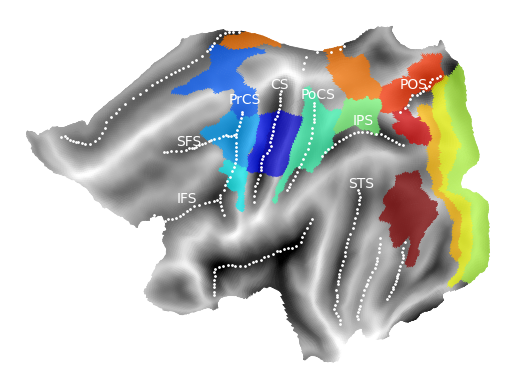

In [18]:
N = len(np.unique(mask)) - 1
g = plot_surf(mask, cmap=cm.jet.resampled(N+1))

In [19]:
def get_df(list_cond):
    df = pd.DataFrame(columns=['roi', 'cue', 'cond', *['S'+sn for sn in list_sn]])
    for aa, cue in enumerate(['letter','spatial']):
        for bb, cond in enumerate(list_cond):
            fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s_%s.dscalar.nii'%(hem,glm,cond,cue))
            cii = nb.load(fname)
            data = cii.get_fdata()
            for ii, roi in enumerate(list_roi):
                row = aa*len(list_cond)*len(list_roi) + bb*len(list_roi) + ii
                val = ii+1
                idx = mask==val
                # nvoxels = (idx).sum()
                # print(val, roi, nvoxels)
            
                tmp = data[:,idx].mean(axis=1)
            
                df.loc[row,'roi'] = roi
                df.loc[row,'cue'] = cue
                df.loc[row,'cond'] = cond
                for jj, psc in enumerate(tmp):
                    subj = 'S'+list_sn[jj]
                    df.loc[row,subj] = psc
    return df

In [20]:
dir_work = join(dir_surf,'glm_%1d'%glm)

list_cond = ['B','S','C','N']
dg = get_df(list_cond)

list_cond = ['wRS','acRS']
df = get_df(list_cond)

In [21]:
dg = pd.melt(
    dg,
    id_vars=['roi','cue','cond'],
    value_vars=['S'+sn for sn in list_sn], var_name='subj',
    value_name='psc'
)
dg['hue'] = ['%s_%s'%(cond,cue) for cond, cue in zip(dg.cond, dg.cue)]
dg

,roi,cue,cond,subj,psc,hue
0,S1,letter,B,S01,19.027311,B_letter
1,M1,letter,B,S01,27.459577,B_letter
2,SMA,letter,B,S01,12.451778,B_letter
3,PMd,letter,B,S01,16.430805,B_letter
4,PMv,letter,B,S01,13.069483,B_letter
...,...,...,...,...,...,...
1339,V3,spatial,N,S14,-24.59902,N_spatial
1340,A,spatial,N,S14,-15.706726,N_spatial
1341,B,spatial,N,S14,-18.550272,N_spatial
1342,C,spatial,N,S14,4.675471,N_spatial


In [22]:
palette = ['#d71b3b','#7a2048','#16acea','#4203c9']

V1 t(11)=0.3065, p=7.649e-01(ns)
V1 t(11)=0.5440, p=5.973e-01(ns)
V1 t(11)=0.4690, p=6.482e-01(ns)
V1 t(11)=0.2948, p=7.736e-01(ns)
V2 t(11)=-1.2199, p=2.480e-01(ns)
V2 t(11)=-1.4205, p=1.832e-01(ns)
V2 t(11)=-0.9899, p=3.435e-01(ns)
V2 t(11)=-1.4484, p=1.754e-01(ns)
V2 t(11)=2.1382, p=5.578e-02(ns)
V3 t(11)=-0.6271, p=5.434e-01(ns)
V3 t(11)=0.7308, p=4.802e-01(ns)
V3 t(11)=-0.7897, p=4.464e-01(ns)
V3 t(11)=0.5085, p=6.211e-01(ns)
C t(11)=-1.3271, p=2.113e-01(ns)
C t(11)=-0.7273, p=4.823e-01(ns)
C t(11)=-1.3411, p=2.069e-01(ns)
C t(11)=-0.6675, p=5.182e-01(ns)


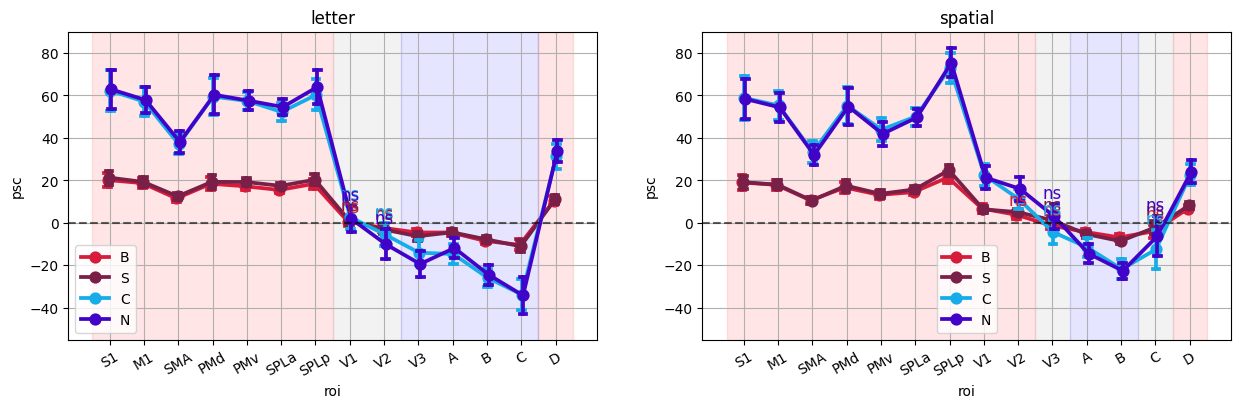

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))

for ii, cue in enumerate(['letter','spatial']):
    ax = axs[ii]
    plt.sca(ax)
    g = sns.pointplot(
        data=dg[dg.cue==cue],
        x='roi', y='psc', hue='cond',
        errorbar='se', capsize=0.2,
        dodge=True,
        palette=palette
    )
    g.legend(loc='best')
    g.grid(axis='both')
    xticks = np.array(g.get_xticks()); g.set_xticks(xticks) 
    xticklabels = g.get_xticklabels(); g.set_xticklabels(xticklabels, rotation=30)
    g.set_ylim(-55,90)
    g.axhline(y=0, linestyle='--', color='black', alpha=0.6)
    g.set_title(cue, fontsize=12)

    ## shader
    tmp = np.append(xticks,xticks[-1]+1)
    if cue == 'letter':
        x1, x2, x3, x4 = 6, 8, 12, 12
    elif cue == 'spatial':
        x1, x2, x3, x4 = 8, 9, 11, 12
    g.fill_between(
            x=tmp-0.5,
            y1=-100, y2=100,
            where=(tmp<=x1+1)|(tmp>x4),
            color='red', alpha=0.1
        )
    g.fill_between(
            x=tmp-0.5,
            y1=-100, y2=100,
            where=(tmp>x1)&(tmp<=x2+1)|(tmp>x3)&(tmp<=x4+1),
            color='gray', alpha=0.1
        )
    g.fill_between(
            x=tmp-0.5,
            y1=-100, y2=100,
            where=(tmp>x2)&(tmp<=x3+1),
            color='blue', alpha=0.1
        )

    ## one sample t-test
    for jj, roi in enumerate(list_roi):
        for kk, c in enumerate(['B','S','C','N']):
            a = dg[(dg.cue==cue)&(dg.roi==roi)&(dg.cond==c)].psc.astype(float)
            res = ttest_1samp(a=a, popmean=0)
            if res.pvalue > 0.05:
                print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
                x = jj
                y = a.mean()+a.sem() + 5
                g.text(
                    x=x, y=y,
                    s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
                    color=palette[kk],
                    ha='center', va='center'
                )

In [24]:
df = pd.melt(
    df,
    id_vars=['roi','cue','cond'],
    value_vars=['S'+sn for sn in list_sn], var_name='subj',
    value_name='psc'
)
df['hue'] = ['%s_%s'%(cond,cue) for cond, cue in zip(df.cond, df.cue)]
df

,roi,cue,cond,subj,psc,hue
0,S1,letter,wRS,S01,0.942154,wRS_letter
1,M1,letter,wRS,S01,-1.129354,wRS_letter
2,SMA,letter,wRS,S01,-1.255739,wRS_letter
3,PMd,letter,wRS,S01,-0.760718,wRS_letter
4,PMv,letter,wRS,S01,-1.875468,wRS_letter
...,...,...,...,...,...,...
667,V3,spatial,acRS,S14,10.293413,acRS_spatial
668,A,spatial,acRS,S14,5.982566,acRS_spatial
669,B,spatial,acRS,S14,7.053149,acRS_spatial
670,C,spatial,acRS,S14,0.401546,acRS_spatial


In [25]:
palette = ['#1d3c45','#d2601a']

PMv t(11)=-3.5497, p=4.555e-03(**)
SPLa t(11)=-2.3674, p=3.732e-02(*)
SPLp t(11)=-3.0974, p=1.015e-02(*)
V3 t(11)=2.7004, p=2.064e-02(*)
V3 t(11)=-2.4954, p=2.975e-02(*)
V3 t(11)=-2.8848, p=1.484e-02(*)
A t(11)=2.2400, p=4.670e-02(*)


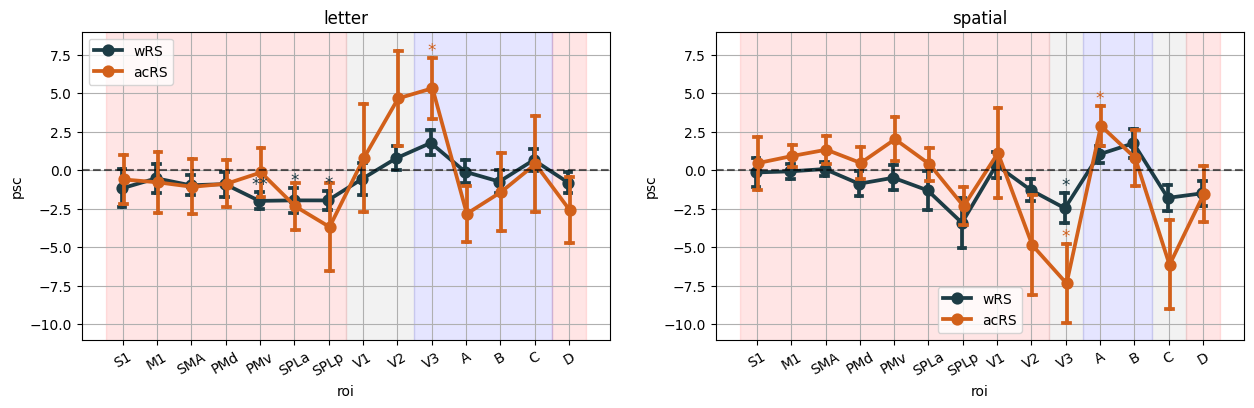

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))

for ii, cue in enumerate(['letter','spatial']):
    ax = axs[ii]
    plt.sca(ax)
    g = sns.pointplot(
        data=df[df.cue==cue],
        x='roi', y='psc', hue='cond',
        errorbar='se', capsize=0.2,
        dodge=True,
        palette=palette
    )
    g.legend(loc='best')
    g.grid(axis='both')
    g.set_xticks(g.get_xticks())
    xticklabels = g.get_xticklabels()
    g.set_xticklabels(xticklabels, rotation=30)
    g.set_ylim(-11,9)
    g.axhline(y=0, linestyle='--', color='black', alpha=0.6)
    g.set_title(cue, fontsize=12)

    ## shader
    tmp = np.append(xticks,xticks[-1]+1)
    if cue == 'letter':
        x1, x2, x3, x4 = 6, 8, 12, 12
    elif cue == 'spatial':
        x1, x2, x3, x4 = 8, 9, 11, 12
    g.fill_between(
            x=tmp-0.5,
            y1=-100, y2=100,
            where=(tmp<=x1+1)|(tmp>x4),
            color='red', alpha=0.1
        )
    g.fill_between(
            x=tmp-0.5,
            y1=-100, y2=100,
            where=(tmp>x1)&(tmp<=x2+1)|(tmp>x3)&(tmp<=x4+1),
            color='gray', alpha=0.1
        )
    g.fill_between(
            x=tmp-0.5,
            y1=-100, y2=100,
            where=(tmp>x2)&(tmp<=x3+1),
            color='blue', alpha=0.1
        )

    ## one sample t-test
    for jj, roi in enumerate(list_roi):
        for kk, c in enumerate(['wRS','acRS']):
            a = df[(df.cue==cue)&(df.roi==roi)&(df.cond==c)].psc.astype(float)
            res = ttest_1samp(a=a, popmean=0)
            if res.pvalue < 0.05:
                print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
                x = jj
                y = a.mean()+a.sem() + 0.5
                g.text(
                    x=x, y=y,
                    s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
                    color=palette[kk],
                    ha='center', va='center'
                )
    
    # ## paired t-test
    # for jj, roi in enumerate(list_roi):
    #     a = df[(df.cue==cue)&(df.roi==roi)&(df.cond=='wRS')].psc.astype(float)
    #     b = df[(df.cue==cue)&(df.roi==roi)&(df.cond=='acRS')].psc.astype(float)
    #     res = ttest_rel(a=a, b=b)
    #     if res.pvalue < 0.05:
    #         print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
    #         x = jj
    #         amax, amin = a.mean()+a.sem(), a.mean()-a.sem()
    #         bmax, bmin = b.mean()+b.sem(), b.mean()-b.sem()
    #         y = max(amax, bmax)+0.5
    #         g.text(
    #             x=x, y=y,
    #             s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
    #             ha='center', va='center'
    #         )

---
---

In [29]:
glob(join(dir_group,'*.t_stat.*.nii'))

['/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_1.t_stat.letter.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_1.t_stat.spatial.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_2.t_stat.acRS_letter.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_2.t_stat.acRS_spatial.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_2.t_stat.B_letter.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_2.t_stat.B_spatial.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_2.t_stat.C_letter.dscalar.nii',
 '/Volumes/Diedrichsen_data$/data/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group/cifti.L.glm_2.t_stat.C_spatial.dscalar.nii',
 '

### Letter

In [30]:
cmap = cm.seismic

In [31]:
thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=len(list_sn)-1)

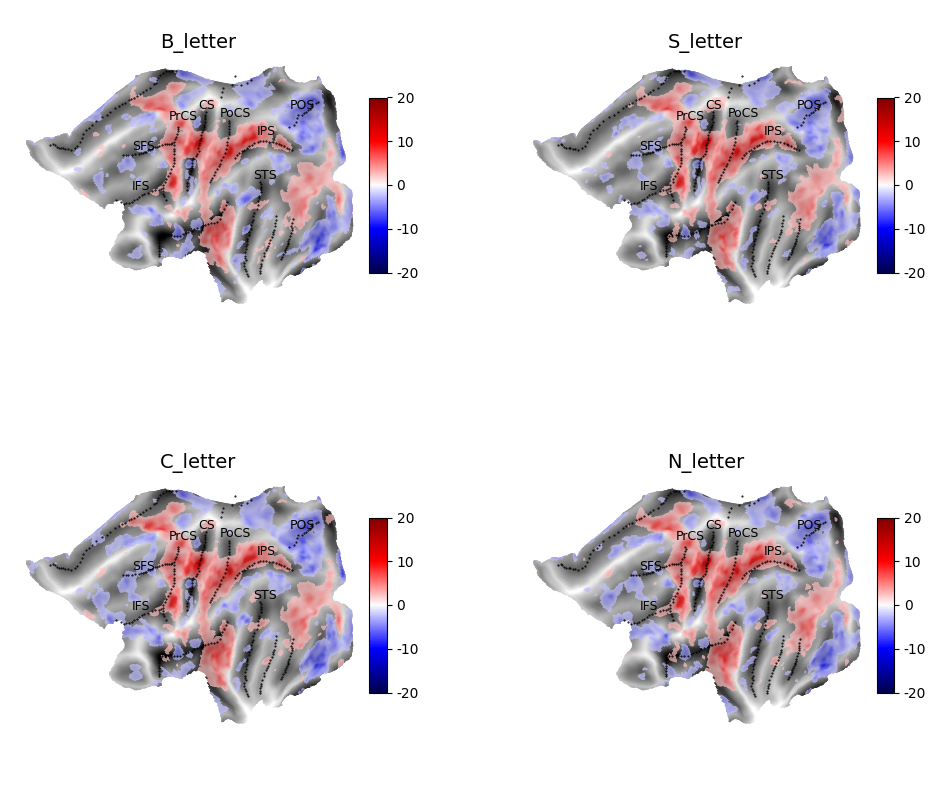

In [32]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
axs = np.concatenate(axs)

cue = 'letter'
for ii, cc in enumerate(['B','S','C','N']):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = cc+'_%s'%cue
    fname = join(dir_group,'cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,cond))
    data = np.array(nb.load(fname).get_fdata())

    color = 'black'
    g = surf.plot.plotmap(
        data=data[1],
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-20,20],
        threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=cond, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

### Spatial

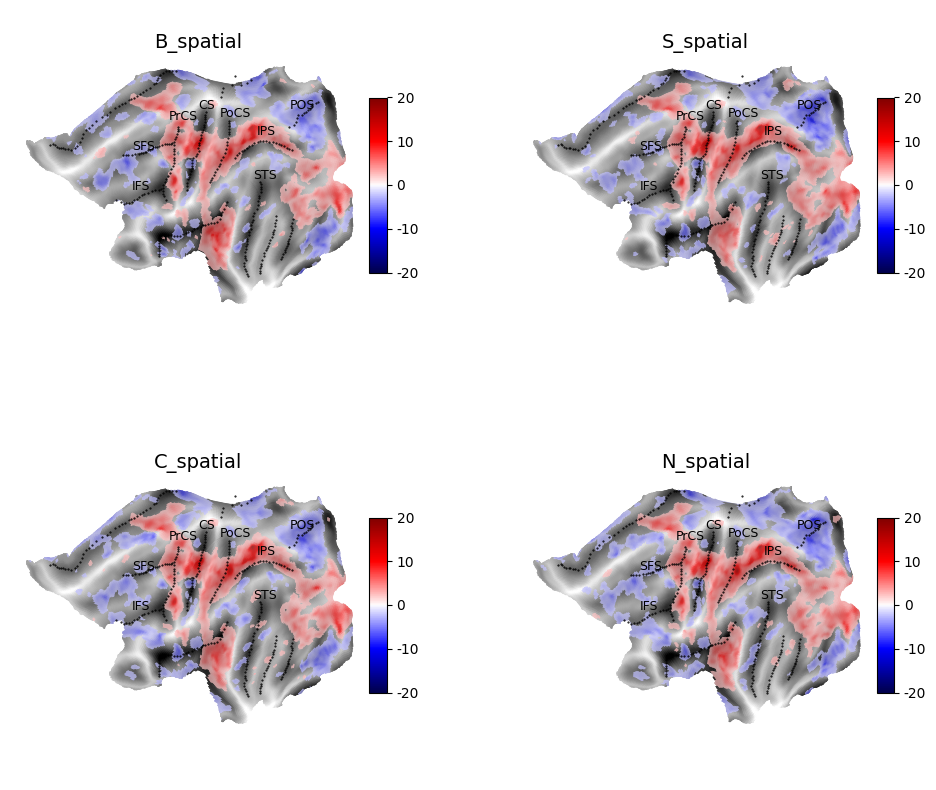

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))
axs = np.concatenate(axs)

cue = 'spatial'
for ii, cc in enumerate(['B','S','C','N']):
    ax = axs[ii]
    plt.sca(ax)
    
    cond = cc+'_%s'%cue
    fname = join(dir_group,'cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,cond))
    data = np.array(nb.load(fname).get_fdata())
    
    color = 'black'
    g = surf.plot.plotmap(
        data=data[1],
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-20,20],
        threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=cond, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

### within Cue

In [34]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

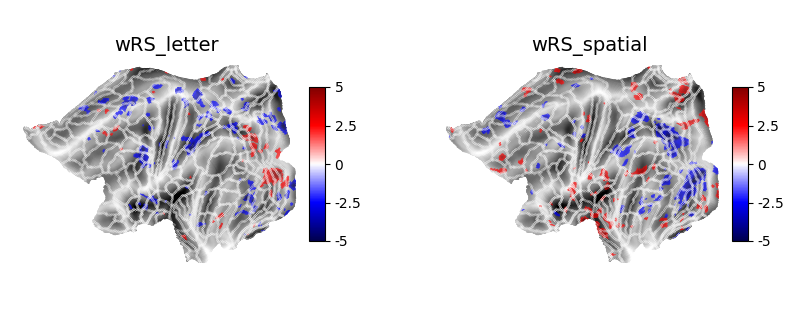

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, sss in enumerate(['wRS_letter','wRS_spatial']):
    ax=axs[ii]
    plt.sca(ax)
    fname = join(dir_group,'cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,sss))
    data = np.array(nb.load(fname).get_fdata())
    
    color = 'white'
    g = surf.plot.plotmap(
        data=data[1],
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-5,5],
        threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=0.15,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

In [23]:
# fig.savefig(
#     join(dir_result, 'wRS.png'),
#     dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

### across Cue

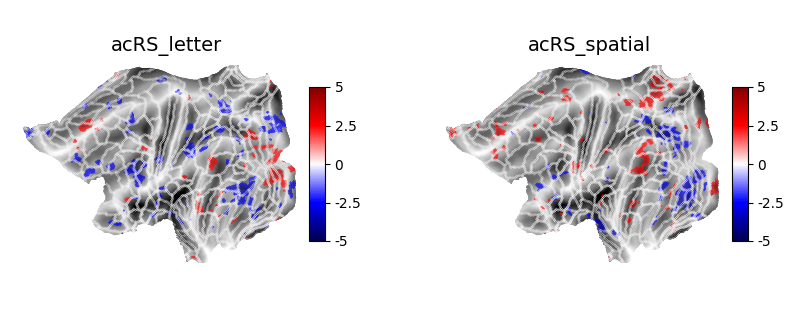

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, sss in enumerate(['acRS_letter','acRS_spatial']):
    ax=axs[ii]
    plt.sca(ax)
    fname = join(dir_group,'cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,sss))
    data = np.array(nb.load(fname).get_fdata())
    
    color = 'white'
    g = surf.plot.plotmap(
        data=data[1],
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap, colorbar=True,
        cscale=[-5,5],
        threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=0.15,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

In [25]:
# fig.savefig(
#     join(dir_result, 'acRS.png'),
#     dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

---